# Ellipses Project (Dvir Samuel)

## Data Preprocessing

In [1]:
import numpy as np
from numpy import genfromtxt
from PIL import Image
import pandas as pd
from collections import Counter
import keras
from keras.layers import Input, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
%matplotlib inline

C:\Users\Dvirsamuel\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load train data
train_data = pd.read_csv("train_data.txt",delimiter=", ",header=0, engine='python')
# organazie the data and seperate to different dataframes
seperated_col = train_data[train_data.columns[0]].str.partition(" ")[[0,2]]
X_train_images = seperated_col[[0]].rename(columns = {0:'paths'})
Y_train_class = seperated_col[[2]].rename(columns = {2:'class'})
del train_data[train_data.columns[0]]
Y_train_features = train_data

##### Training images paths

In [3]:
X_train_images.head()

,paths
0,images/train/0000.jpg
1,images/train/0001.jpg
2,images/train/0002.jpg
3,images/train/0003.jpg
4,images/train/0004.jpg


##### Training true labels - ellipse or not

In [4]:
Y_train_class.head()

,class
0,False
1,True
2,False
3,False
4,True


##### Training true features - ellipse parameters

In [5]:
Y_train_features.head()

,center_x,center_y,angle,axis_1,axis_2
0,0,0,0,0,0
1,34,32,25,16,17
2,0,0,0,0,0
3,0,0,0,0,0
4,18,19,150,20,15


##### Normalize the angles
If angles are greater than 180 degrees we can normalize them

In [6]:
Y_train_features['angle'] = Y_train_features['angle']%180

In [7]:
# Load test data
test_data = pd.read_csv("test_data.txt",delimiter=", ",header=0, engine='python')
# organazie the data and seperate to different dataframes
seperated_col = test_data[test_data.columns[0]].str.partition(" ")[[0,2]]
X_test_images = seperated_col[[0]].rename(columns = {0:'paths'})
Y_test_class = seperated_col[[2]].rename(columns = {2:'class'})
del test_data[test_data.columns[0]]
Y_test_features = test_data
# normalaize angles
Y_test_features['angle'] = Y_test_features['angle']%180

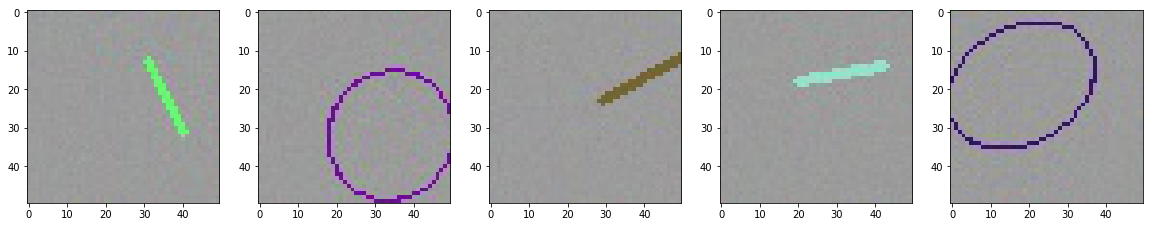

In [8]:
# show some data samples
fig = plt.figure(figsize=(20,20))
for idx,path in enumerate(X_train_images['paths'].head()):
    img = Image.open(path)
    fig.add_subplot(1,5,idx+1)
    plt.imshow(img)

In [9]:
# load train images to memory
X_train_o = np.array([np.array(Image.open(path)) for path in X_train_images['paths']]).astype('float32')
X_test_o = np.array([np.array(Image.open(path)) for path in X_test_images['paths']]).astype('float32')
print("Train shape:", X_train_o.shape)
print("Test shape:", X_test_o.shape)

Train shape: (10000, 50, 50, 3)
Test shape: (1000, 50, 50, 3)


In [10]:
# normalize rgb images
X_train = X_train_o / 255
X_test = X_test_o / 255
# y to one-hote encoding
Y_train_class['class'] = (Y_train_class['class'].values == 'True').astype(float)
Y_test_class['class'] = (Y_test_class['class'].values == 'True').astype(float)

## Data Distribuation
### Check if data is balanced

In [11]:
print("Train Data:")
print(Counter(Y_train_class['class']))
print("Test Data")
print(Counter(Y_test_class['class']))

Train Data:
Counter({1.0: 6997, 0.0: 3003})
Test Data
Counter({1.0: 688, 0.0: 312})


As we can see, there are more ellipses than non-ellipses (greater by almost 2.4) - in training we will give all non ellipses data more weight

In [12]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train_class), Y_train_class["class"])
class_weights = {cid : weight for cid, weight in enumerate(class_weights)}
print(class_weights)

{0: 1.665001665001665, 1: 0.7145919679862799}


## Approach 1: Image Processing method 
  #### I will try first to see if we could get reasonable results using opencv with traditional image processing methods

I tried playing with contour and fitEllipse, but it did not give good results.
Most of the time it couldn't find the ellipses if they where drawn in the image..

## Approach 2: Deep Learning method 
#### I will try and implement a cnn network which outputs True/False if , and the features

In [13]:
# build the model
img_input = Input(X_train.shape[1:])
conv1 = Conv2D(32, (5,5), name='conv1', activation='relu')(img_input)
bn1 = BatchNormalization(name='bn1', axis=3)(conv1)
conv2 = Conv2D(32, (5,5), name='conv2', activation='relu')(bn1)
bn2 = BatchNormalization(name='bn2', axis=3)(conv2)
maxp1 = MaxPooling2D(name='maxp1')(bn2)
conv3 = Conv2D(32, (3,3), name='conv3', activation='relu')(maxp1)
bn3 = BatchNormalization(name='bn3', axis=3)(conv3)
conv4 = Conv2D(64, (3,3), name='conv4', activation='relu')(bn3)
bn4 = BatchNormalization(name='bn4', axis=3)(conv4)
maxp2 = MaxPooling2D(name='maxp2')(bn4)
conv5 = Conv2D(128, (3,3), name='conv5', activation='relu')(maxp2)
bn5 = BatchNormalization(name='bn5', axis=3)(conv5)
conv6 = Conv2D(256, (2,2), name='conv6', activation='relu')(bn5)
globap = GlobalAveragePooling2D(name='globalAVGp')(conv6)
# Left branch - ellipse or not (classifications)
ldense1 = Dense(512,name='ldense1',activation='relu')(globap)
lbn6 = BatchNormalization(name='lbn6')(ldense1)
classification = Dense(1, activation='sigmoid', name='class')(lbn6)
# right branch - ellipses features
rdense1 = Dense(512,name='rdense1', activation='relu')(globap)
rbn6 = BatchNormalization(name='rbn6')(rdense1)
rdense2 = Dense(256,name='rdense2', activation='relu')(rbn6)
rbn7 = BatchNormalization(name='rbn7')(rdense2)
features = Dense(Y_train_features.shape[-1], name='features')(rbn7)

model = Model(img_input, [classification,features])
model.summary()
plot_model(model, to_file="model.png")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 46, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 46, 46, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 42, 42, 32)   25632       bn1[0][0]                        
__________________________________________________________________________________________________
bn2 (Batch

Model structure:


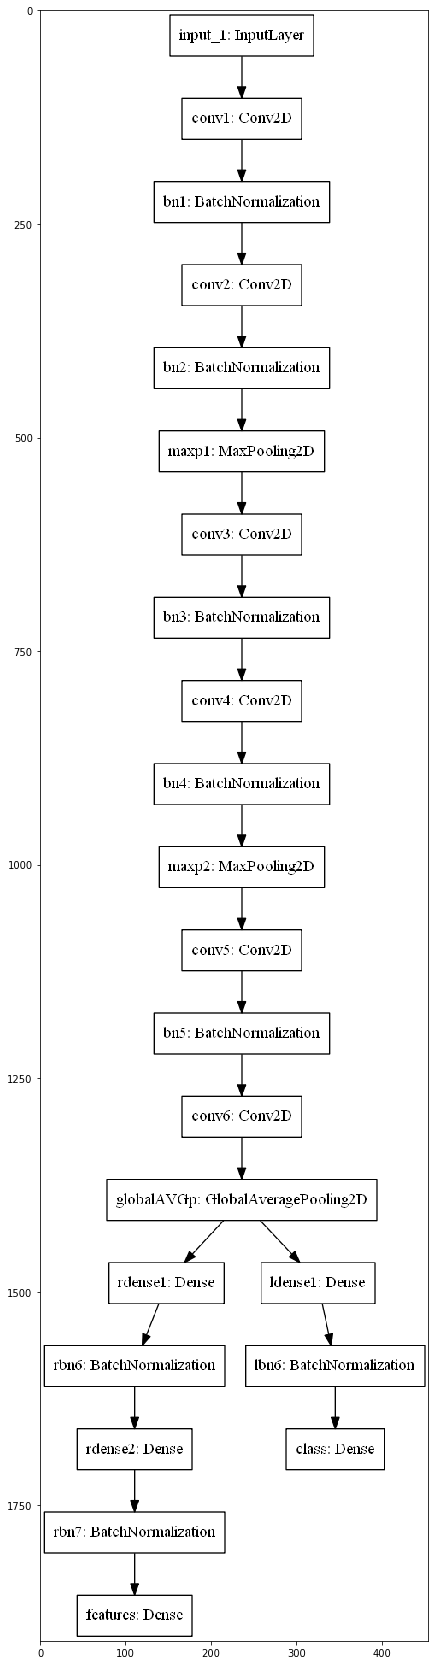

In [14]:
print("Model structure:")
fig = plt.figure(figsize=(25,30))
model_img = Image.open("model.png")
plt.imshow(model_img)

#### Model training

In [24]:
# hyperparams
epochs = 10
batch_size = 64
optAlgo = Adam(lr=0.0001)

# compile model
model.compile(optAlgo,loss=['binary_crossentropy','mse'], metrics=['accuracy'],loss_weights=[1.,.001])

# values to track:
save_to = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath=save_to, verbose=0, save_best_only=True)
callbacks = [checkpoint]

In [25]:
# train model
history = model.fit(X_train, [Y_train_class,Y_train_features], shuffle=True, batch_size=batch_size, 
                             epochs=epochs, verbose=1, validation_split=0.3, callbacks = callbacks)

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 24s 3ms/step - loss: 0.3365 - class_loss: 0.0048 - features_loss: 331.7034 - class_acc: 0.9986 - features_acc: 0.6001 - val_loss: 0.5140 - val_class_loss: 0.0631 - val_features_loss: 450.8444 - val_class_acc: 0.9790 - val_features_acc: 0.5907
Epoch 2/10
7000/7000 [==============================] - 21s 3ms/step - loss: 0.3187 - class_loss: 0.0034 - features_loss: 315.3027 - class_acc: 0.9990 - features_acc: 0.5996 - val_loss: 0.9719 - val_class_loss: 0.4849 - val_features_loss: 487.0026 - val_class_acc: 0.8923 - val_features_acc: 0.6067
Epoch 3/10
7000/7000 [==============================] - 21s 3ms/step - loss: 0.2997 - class_loss: 0.0021 - features_loss: 297.6817 - class_acc: 0.9996 - features_acc: 0.5990 - val_loss: 0.9770 - val_class_loss: 0.3858 - val_features_loss: 591.2103 - val_class_acc: 0.9047 - val_features_acc: 0.6043
Epoch 4/10
7000/7000 [==============================] -

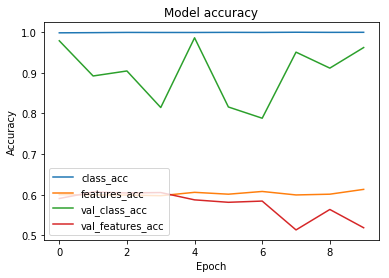

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['class_acc'])
plt.plot(history.history['features_acc'])
plt.plot(history.history['val_class_acc'])
plt.plot(history.history['val_features_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['class_acc','features_acc','val_class_acc', 'val_features_acc'], loc='lower left')
plt.show()

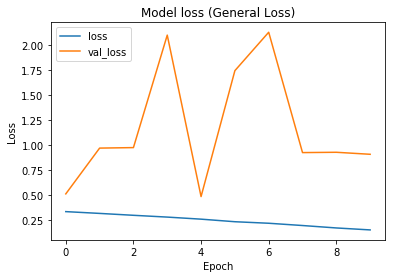

In [35]:
# Plot training & validation loss values (general loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (General Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

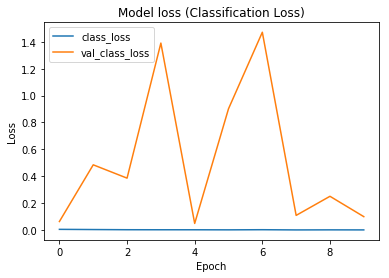

In [34]:
# Plot training & validation loss values (classification loss)
plt.plot(history.history['class_loss'])
plt.plot(history.history['val_class_loss'])
plt.title('Model loss (Classification Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['class_loss','val_class_loss'], loc='upper left')
plt.show()

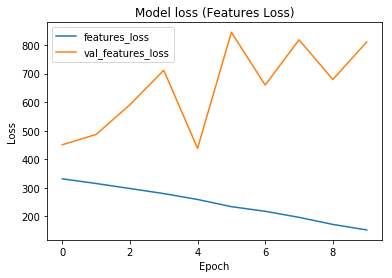

In [33]:
# Plot training & validation loss values (features loss)
plt.plot(history.history['features_loss'])
plt.plot(history.history['val_features_loss'])
plt.title('Model loss (Features Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['features_loss','val_features_loss'], loc='upper left')
plt.show()

#### Model evaluation

In [31]:
# load best model wights
model.load_weights(save_to)
# loss,features_l,ellipses_l,featres_a,ellipses_a
_,_,_,acc_classes,acc_features = model.evaluate(X_test, [Y_test_class,Y_test_features])
print('Test Features Acc:', acc_features)
print('Test Classification Acc:', acc_classes)

1000/1000 [==============================] - 1s 883us/step
Test Features Acc: 0.562
Test Classification Acc: 0.986


In [37]:
# Check errors
features_predicted = model.predict(X_test)[1]
for feat,error in zip(["center_x","center_y","angle","axis_1","axis_2"],
                      (pd.DataFrame(features_predicted) - Y_test_features.values).abs().mean()):
    if feat == "angle":
        continue #we will evaluate error later...
    print(feat,"avg error:",error)

# check error percentages for angle
angle_idx = Y_test_features.columns.get_loc("angle")
predicted_angles = pd.DataFrame(features_predicted)
err_percentage = ((Y_test_features[Y_test_features.columns[angle_idx]] 
                     - predicted_angles[predicted_angles.columns[angle_idx]]).abs())/100
print("Avg angle error:", err_percentage.mean())
print(len(list(filter(lambda x: x,err_percentage > 0.05))),"of",len(predicted_angles),"has angle error grater than 5%")

center_x avg error: 3.31393098372221
center_y avg error: 3.5711130644977094
axis_1 avg error: 4.034319876626134
axis_2 avg error: 3.9361904185712335
Avg angle error: 0.33388948690175974
711 of 1000 has angle error grater than 5%
